# Customer Segmentation - Step 2: Clustering

In [1]:
# input : seed data
output_dataset = 'USER_SXM4690'
cs_seed_table = 'cs_seed'

# output: clustering index and dominate department for class level subclustering
dept_temp_table = 'cs_temp_cluster'
dominate_dept_table = 'cs_temp_cluster_dom_dept'
cs_class_pen_table = 'cs_temp_class_penetration'

## 1. Clustering

In [8]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from operator import itemgetter

def load_to_BQ_table(table_name, dataframe):
  
  import pandas as pd
  # rename data frame columns
  dataframe.columns = dataframe.columns.str.replace('\s+', '_')
  dataframe.columns = dataframe.columns.str.replace('/', '_')
  dataframe.columns = dataframe.columns.str.replace('(', '_')
  dataframe.columns = dataframe.columns.str.replace(')', '_')
  dataframe = dataframe.where(pd.notnull(dataframe), None)
  
  # define table
  import datalab.bigquery as bq
  bq_table = bq.Table(output_dataset + '.' + table_name)
  bq_table.delete()

  # create schema
  if not bq_table.exists():
    table_schema = bq.Schema.from_dataframe(dataframe)
    bq_table.create(schema = table_schema, overwrite = True)

  # load data
  bq_table.insert_data(dataframe)
  
  # show sample data
  return(dataframe.head())


def cal_cluster_silhouette(dataset, clusters):
       
    clusterer = KMeans(init='k-means++', n_jobs=1, n_clusters=clusters, n_init=10, random_state=5)
    cluster_labels = clusterer.fit_predict(dataset)
    silhouette_avg = silhouette_score(dataset, cluster_labels, sample_size=min(10000, len(dataset.index)), random_state=5)
    
    print(str(clusters) + ': ' + str(silhouette_avg))
    return (clusters, silhouette_avg)
  
  
def clustering(dataset, min_clusters, max_clusters, cluster_col):
  if cluster_col == 'cluster':
    input_df_scaled = dataset.iloc[:,4:len(dataset.columns)]
    input_df_scaled = StandardScaler().fit_transform(input_df_scaled)
    input_df_scaled = pd.DataFrame(input_df_scaled)
    
  elif cluster_col == 'subcluster':
    input_df_scaled = dataset.iloc[:,2:len(dataset.columns)]
    
  elif cluster_col == 'subcluster_class':
    input_df_scaled = dataset.iloc[:,1:len(dataset.columns)]
  
  range_n_clusters = range(min_clusters, max_clusters+1)
  avg_silhouette = [] # create a list for number of clusters and average silhouette value
  
  for i in range_n_clusters:
    avg_silhouette.append(cal_cluster_silhouette(input_df_scaled, i))

  recommended_clusters = max(avg_silhouette,key=itemgetter(1))[0] # recommend num of clusters with highest silhouette

  mbk = KMeans(init='k-means++', n_jobs=1, n_clusters=recommended_clusters, n_init=10,  random_state=5)

  cluster_labels = mbk.fit_predict(input_df_scaled)
  
  dataset['cluster_temp'] = cluster_labels + 1

  # adjust cluster index by number of customers
  # reorder cluster number based on R12 sales
  cluster_size = dataset.groupby('cluster_temp').agg({'cust_id': 'count'}).reset_index()
  cluster_size['cluster_new'] = cluster_size['cust_id'].rank(ascending=False, method='first')

  # update new cluster index
  dataset = dataset.merge(cluster_size[['cluster_temp', 'cluster_new']], on='cluster_temp')
  dataset = dataset.drop(['cluster_temp'], axis=1).rename(columns = {'cluster_new': cluster_col})
  
  return (dataset)


In [3]:
%%bq query -n cs_seed_dept
SELECT cust_id, s_trd_typ_desc, dept_nbr, dept_nm, sum(categ_r12_sls_amt) as categ_r12_sls_amt,
avg(tot_r12_txn_cnt) as tot_r12_txn_cnt, avg(tot_r12_sls_amt) as tot_r12_sls_amt
FROM `analytics-pricing-thd.USER_SXM4690.cs_seed` 
where dept_nbr is not null
group by 1,2,3,4

In [4]:
# Pull seed data into a pandas dataframe
import google.datalab.bigquery as bq
cs_seed_df = cs_seed_dept.execute(output_options=bq.QueryOutput.dataframe()).result()

In [5]:
# Pick customer level variable
cs_seed_var = cs_seed_df.loc[:, ['cust_id', 's_trd_typ_desc', 'tot_r12_txn_cnt', 'tot_r12_sls_amt']].drop_duplicates()
cs_seed_var = cs_seed_var.round({'tot_r12_txn_cnt': 0,'tot_r12_sls_amt': 0})

# Add dept name
cs_seed_dept = cs_seed_df.assign(dept = 'D' + cs_seed_df.dept_nbr.astype(str) + '_' + cs_seed_df.dept_nm,
                               dept_r12_sls_pcnt=cs_seed_df.categ_r12_sls_amt / cs_seed_df.tot_r12_sls_amt)

# Calculate department penetration
cs_seed_dept = cs_seed_dept.groupby(['cust_id', 'dept']).agg({'dept_r12_sls_pcnt': 'sum'}).reset_index()
cs_seed_dept = cs_seed_dept.round({'dept_r12_sls_pcnt': 3})

# Reshape department penetration into wide format so each department is a separate column
cs_seed_dept = cs_seed_dept.pivot(index='cust_id', columns='dept', values='dept_r12_sls_pcnt').reset_index()
cs_seed_dept = cs_seed_dept.fillna(0)

# Join customer level variables with dept penetration
cs_seed_var = cs_seed_var.merge(cs_seed_dept, on='cust_id')

# Exclude zero and negative sales
cs_seed_var = cs_seed_var[cs_seed_var.tot_r12_sls_amt >0 ]

print('There are a total of ' + str(len(cs_seed_var.index)) + ' customers. ')
cs_seed_var.head()

There are a total of 54694 customers. 


,cust_id,s_trd_typ_desc,tot_r12_txn_cnt,tot_r12_sls_amt,D0021_LUMBER,D0022_BUILDING MATERIALS,D0024_PAINT,D0030_MILLWORK,D023F_WALL/FLOOR COVERING,D025H_HARDWARE (25H),D025T_TOOLS (25T),D026P_PLUMBING,D027E_ELECTRICAL,D027L_LIGHTING,D028I_GRD/INDOOR,D028O_GRD/OUTDOOR,D029A_APPLIANCES,D029B_KITCHEN AND BATH,D059S_STORAGE
0,38514786,Remodeler,2.0,17460.0,0.394,0.525,0.0,0.074,0.000,0.0,0.007,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0
1,4438824,Institutional,2.0,1676.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.000,0.0
2,46402179,Electrician,2.0,19936.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.0,0.978,0.022,0.0,0.0,0.0,0.000,0.0
3,2541061,Commercial Constr.,2.0,6623.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.0,1.0,0.000,0.0
4,29711022,Property Manager,2.0,10308.0,0.000,0.000,0.0,0.000,0.001,0.0,0.000,0.0,0.901,0.000,0.0,0.0,0.0,0.098,0.0


In [6]:
# Call clustering function
cs_cluster = clustering(cs_seed_var, 12, 20, 'cluster')

12: 0.20188439524289628
13: 0.21190356313651076
14: 0.21626383563592153
15: 0.21977209832698918
16: 0.18876363357245524
17: 0.1609377045147401
18: 0.163360922238437
19: 0.16289548864043654
20: 0.16335834937850477


In [9]:
# load clustering result to BQ table
load_to_BQ_table(dept_temp_table, cs_cluster)

,cust_id,s_trd_typ_desc,tot_r12_txn_cnt,tot_r12_sls_amt,D0021_LUMBER,D0022_BUILDING_MATERIALS,D0024_PAINT,D0030_MILLWORK,D023F_WALL_FLOOR_COVERING,D025H_HARDWARE__25H_,D025T_TOOLS__25T_,D026P_PLUMBING,D027E_ELECTRICAL,D027L_LIGHTING,D028I_GRD_INDOOR,D028O_GRD_OUTDOOR,D029A_APPLIANCES,D029B_KITCHEN_AND_BATH,D059S_STORAGE,cluster
0,38514786,Remodeler,2.0,17460.0,0.394,0.525,0.0,0.074,0.000,0.000,0.007,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,6.0
1,2608919,Other,2.0,215.0,0.000,0.848,0.0,0.000,0.000,0.046,0.000,0.0,0.0,0.0,0.0,0.106,0.0,0.000,0.0,6.0
2,2564091,Roofer,2.0,4734.0,0.000,0.949,0.0,0.000,0.000,0.034,0.017,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,6.0
3,2685836,Remodeler,2.0,15185.0,0.000,0.981,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.019,0.0,6.0
4,1180205,Hospitality,2.0,5172.0,0.217,0.558,0.0,0.000,0.188,0.037,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,6.0


## 2. Visualization

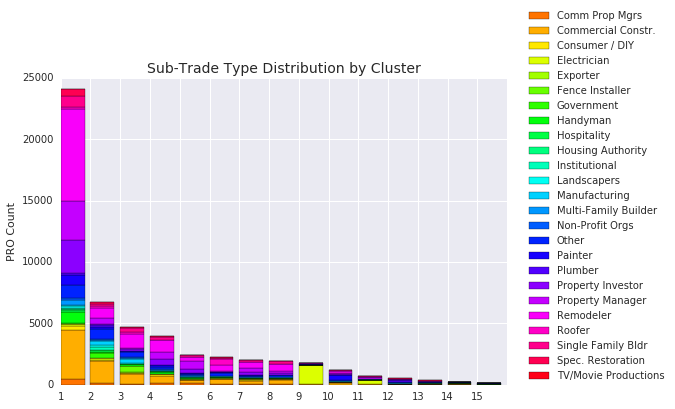

In [10]:
subtrade = cs_cluster.groupby(['cluster', 's_trd_typ_desc'], as_index=False).agg({'cust_id': 'count'}).reset_index()
subtrade_pivot = subtrade.pivot(index='cluster', columns='s_trd_typ_desc', values='cust_id').reset_index()
subtrade_pivot = subtrade_pivot.fillna(0)

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(subtrade_pivot.columns))

# cumulative count
cumu = np.repeat(0, max(subtrade_pivot['cluster']))

for i in range(2,len(subtrade_pivot.columns)):
  d = plt.bar(subtrade_pivot['cluster'], subtrade_pivot.iloc[:,i], bottom=cumu, width=0.8, color=cmap(i), label=subtrade_pivot.columns.values[i])
  cumu = subtrade_pivot.iloc[:,i] + cumu

plt.ylabel('PRO Count')
plt.title('Sub-Trade Type Distribution by Cluster', fontsize=14)

plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(subtrade_pivot['cluster']), max(subtrade_pivot['cluster'])+1, 1.0) )

plt.legend(loc=(1.04,0))

plt.show()


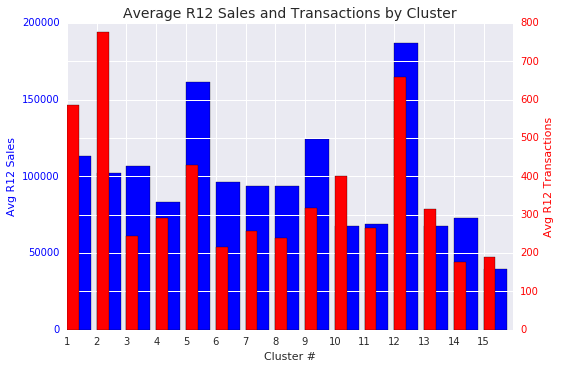

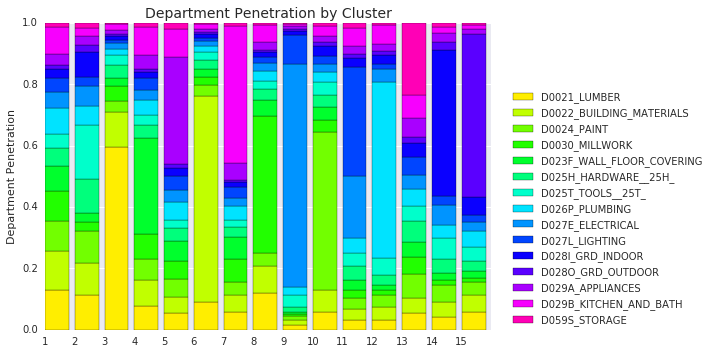

,cluster #,Total R12 Transactions,Total R12 Sales,D0021_LUMBER,D0022_BUILDING_MATERIALS,D0024_PAINT,D0030_MILLWORK,D023F_WALL_FLOOR_COVERING,D025H_HARDWARE__25H_,D025T_TOOLS__25T_,D026P_PLUMBING,D027E_ELECTRICAL,D027L_LIGHTING,D028I_GRD_INDOOR,D028O_GRD_OUTDOOR,D029A_APPLIANCES,D029B_KITCHEN_AND_BATH,D059S_STORAGE
0,1.0,586.0,113002.0,0.129,0.127,0.098,0.099,0.081,0.059,0.043,0.085,0.054,0.044,0.028,0.014,0.038,0.085,0.015
1,2.0,776.0,102309.0,0.114,0.103,0.104,0.029,0.032,0.111,0.177,0.059,0.066,0.029,0.081,0.025,0.029,0.024,0.018
2,3.0,245.0,106827.0,0.596,0.115,0.035,0.049,0.024,0.043,0.033,0.020,0.017,0.011,0.015,0.007,0.011,0.019,0.004
3,4.0,293.0,83204.0,0.077,0.084,0.071,0.081,0.313,0.042,0.031,0.051,0.031,0.039,0.021,0.010,0.045,0.092,0.012
4,5.0,429.0,161589.0,0.054,0.052,0.058,0.061,0.064,0.042,0.027,0.059,0.036,0.047,0.026,0.013,0.348,0.093,0.019
5,6.0,215.0,96278.0,0.092,0.671,0.033,0.029,0.024,0.032,0.026,0.020,0.014,0.010,0.015,0.005,0.011,0.016,0.003
6,7.0,257.0,93523.0,0.059,0.053,0.044,0.073,0.074,0.032,0.022,0.046,0.027,0.035,0.015,0.008,0.053,0.447,0.011
7,8.0,240.0,93974.0,0.119,0.089,0.042,0.447,0.051,0.036,0.026,0.033,0.025,0.022,0.014,0.007,0.028,0.054,0.007
8,9.0,318.0,124439.0,0.015,0.018,0.012,0.007,0.007,0.017,0.037,0.027,0.728,0.092,0.016,0.005,0.009,0.008,0.004
9,10.0,401.0,67718.0,0.060,0.071,0.513,0.040,0.043,0.039,0.040,0.034,0.026,0.024,0.033,0.013,0.020,0.033,0.010


In [11]:
# calculate the average of seed variable value for each cluster
cs_cluster.iloc[:,2:len(cs_cluster.columns)] = cs_cluster.iloc[:,2:len(cs_cluster.columns)].apply(pd.to_numeric)
seed_avg = cs_cluster.iloc[:,2:len(cs_cluster.columns)].groupby(['cluster']).mean().reset_index()

# plot R12 metrics
fig, ax1 = plt.subplots()

ax1.bar(seed_avg['cluster'], seed_avg['tot_r12_sls_amt'], color='b', label='Avg R12 Sales')
ax1.set_xlabel('Cluster #')
ax1.set_ylabel('Avg R12 Sales', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(seed_avg['cluster'], seed_avg['tot_r12_txn_cnt'], color='r', width=0.4)
ax2.set_ylabel('Avg R12 Transactions', color='r')
ax2.tick_params('y', colors='r')

plt.title('Average R12 Sales and Transactions by Cluster', fontsize=14)
plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(seed_avg['cluster']), max(seed_avg['cluster'])+1, 1.0))

plt.show()

# plot dept penetration
cmap = get_cmap(20)

# cumulative spending penetration
cumu = np.repeat(0, max(seed_avg['cluster']))

for i in range(3,len(seed_avg.columns)):
  d = plt.bar(seed_avg['cluster'], seed_avg.iloc[:,i], bottom=cumu, width=0.8, color=cmap(i), label=seed_avg.columns.values[i])
  cumu = seed_avg.iloc[:,i] + cumu

plt.ylabel('Department Penetration')
plt.title('Department Penetration by Cluster', fontsize=14)

plt.gca().set_xlim(left=1)
plt.xticks(np.arange(min(seed_avg['cluster']), max(seed_avg['cluster'])+1, 1.0) )

plt.gca().set_ylim([0,1])

plt.legend(loc=(1.04,0))

plt.show()


# display data
seed_avg = seed_avg.round(3)
seed_avg = seed_avg.round({'tot_r12_txn_cnt': 0,'tot_r12_sls_amt': 0})

seed_avg.rename(columns={'cluster': 'cluster #', 'tot_r12_txn_cnt': 'Total R12 Transactions', 'tot_r12_sls_amt': 'Total R12 Sales'}).reset_index(drop=True)

## 3. Find Dominate Department

In [12]:
# pick a cluster and a department to run class level clustering
cluster_dom_dept = pd.DataFrame({'cluster': [3, 6, 10, 8, 4, 2, 2, 12, 9, 11, 14, 15, 5, 7, 13], 
                             'dept_nbr': ['0021', '0022', '0024', '0030', '023F', '025H', '025T', '026P', '027E', '027L', '028I', '028O', '029A', '029B', '059S']})

# load clustering result to BQ table
load_to_BQ_table(dominate_dept_table, cluster_dom_dept)

cluster_dom_dept

,cluster,dept_nbr
0,3,0021
1,6,0022
2,10,0024
3,8,0030
4,4,023F
5,2,025H
6,2,025T
7,12,026P
8,9,027E
9,11,027L


## 4. Prepare class penetration table

In [13]:
%%bq query -n class_pen
SELECT 
  a.cluster,
  b.cust_id, 
  b.dept_nbr, 
  b.dept_nm, 
  item_class_cd, 
  item_class_desc, 
  categ_r12_sls_amt, 
  sum(categ_r12_sls_amt) over (partition by b.cust_id) as dept_r12_sls_amt,
  categ_r12_sls_amt / sum(categ_r12_sls_amt) over (partition by b.cust_id) as class_penetration
FROM `analytics-pricing-thd.USER_SXM4690.cs_temp_cluster` a
INNER JOIN `analytics-pricing-thd.USER_SXM4690.cs_seed` b
on a.cust_id = b.cust_id
INNER JOIN `analytics-pricing-thd.USER_SXM4690.cs_temp_cluster_dom_dept` c
on cast(a.cluster as int64) = cast(c.cluster as int64)
and b.dept_nbr = c.dept_nbr
where categ_r12_sls_amt > 0

In [14]:
cs_class_pen_table = output_dataset + '.' + cs_class_pen_table                 

In [15]:
%%bq execute -q class_pen -t $cs_class_pen_table -m overwrite

cluster,cust_id,dept_nbr,dept_nm,item_class_cd,item_class_desc,categ_r12_sls_amt,dept_r12_sls_amt,class_penetration
2.0,326,025T,TOOLS (25T),2,FASTENING TOOLS,237.38,10947.87,0.0216827565545
2.0,466,025H,HARDWARE (25H),28,COMPRESSORS AND AIR TOOL,2721.95,93180.55,0.029211568294
2.0,559,025H,HARDWARE (25H),4,BUILDER'S HARDWARE,540.2,17955.61,0.0300853048156
3.0,616,0021,LUMBER,6,STUDS,117191.72,184697.72,0.634505504453
2.0,677,025T,TOOLS (25T),31,GARAGE/AUTOMOTIVE,945.91,6442.42,0.146825261315
2.0,777,025H,HARDWARE (25H),3,FASTENERS,4302.48,9206.91,0.46730987921
12.0,968,026P,PLUMBING,10,WATER HEATERS,11300.15,156615.88,0.0721520065526
2.0,984,025H,HARDWARE (25H),5,SECURITY/SAFETY,158.84,29051.92,0.00546745275355
2.0,1111,025T,TOOLS (25T),9,PORTABLE POWER,14381.73,64383.94,0.223374493701
2.0,1462,025T,TOOLS (25T),1,HAND TOOLS,1747.67,10466.99,0.166969682784
